# Gaussian Mixture Model:
A Gaussian Mixture Model (GMM) is a probabilistic model that assumes data points are generated from a mixture of several Gaussian (normal) distributions with unknown parameters. Unlike hard clustering methods such as K-Means which assign each point to a single cluster based on the closest centroid, GMM performs soft clustering by assigning each point a probability of belonging to multiple clusters.

# Expectation-Maximization (EM) Algorithm:
To fit a Gaussian Mixture Model to the data we use the Expectation-Maximization (EM) algorithm which is an iterative method that optimize the parameters of the Gaussian distributions like mean, covariance and mixing coefficients. It works in two main steps:

# (1)Expectation Step (E-step):
In this step the algorithm calculates the probability that each data point belongs to each cluster based on the current parameter estimates (mean, covariance, mixing coefficients).
# (2)Maximization Step (M-step): 
After estimating the probabilities the algorithm updates the parameters (mean, covariance and mixing coefficients) to better fit the data.

# Akaike Information Criterion (AIC)
AIC is a model selection criterion developed by Hirotugu Akaike that aims to estimate the relative quality of different models while penalizing for model complexity.The purpose of AIC is to find a model that maximizes the likelihood of the data while taking into account the number of parameters used.

# Bayesian Information Criterion (BIC)
Similar to AIC, the Bayesian Information Criterion (BIC) is another model selection criterion that considers both model fit and complexity. BIC is based on Bayesian principles and provides a more stronger penalty for model complexity compared to AIC.


In [48]:
# ================================================================================================================================================================================================
# GMM from scratch — EM algorithm
# =================================================================================================================================================================================================
# First ,We will imort all important libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
#==================================================================================================================================================================================================

In [49]:
# -------------------------
# Utility: Multivariate Normal pdf (vectorized)
# -------------------------
def mvn_pdf(X, mean, cov, reg_covar=1e-6):
    """Here,We are assigning 
    Multivariate normal PDF values for each row in X.in which,
    X: (n_samples, n_features)
    mean: (n_features,)
    cov: (n_features, n_features)
    returns: (n_samples,) density values
    """
    n, d = X.shape
    cov_reg = cov + reg_covar * np.eye(d)
    try:
        inv_cov = np.linalg.inv(cov_reg)
        det_cov = np.linalg.det(cov_reg)
    except np.linalg.LinAlgError:
        # fallback: add larger regularization
        cov_reg = cov + (reg_covar * 10) * np.eye(d)
        inv_cov = np.linalg.inv(cov_reg)
        det_cov = np.linalg.det(cov_reg)
    denom = np.sqrt((2 * np.pi) ** d * (det_cov + 1e-12))
    diff = X - mean
    exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
    return np.exp(exponent) / denom

# =======================================================================================================================================================================================

In [50]:
# GMM-EM implementation
# -------------------------
def gmm_em(X, n_components=3, max_iters=200, tol=1e-6, reg_covar=1e-6, init_method='kmeans', verbose=False):
    """In this function,we will 
    fit a Gaussian Mixture Model using EM.
    Returns dict with parameters, responsibilities, log_likelihoods.
    """
    n, d = X.shape
    K = n_components

    # -------- init means, covs, weights --------
    if init_method == 'kmeans':
        kmeans = KMeans(n_clusters=K, random_state=42).fit(X)
        means = kmeans.cluster_centers_
    else:
        rng = np.random.RandomState(42)
        means = X[rng.choice(n, K, replace=False)]

    # init covariances: use sample cov of whole data, or per-cluster if kmeans
    covs = np.array([np.cov(X.T) + reg_covar * np.eye(d) for _ in range(K)])
    weights = np.ones(K) / K

    log_likelihoods = []
    responsibilities = np.zeros((n, K))

    for it in range(max_iters):
        # -------- E-step: compute responsibilities gamma_{ik} --------
        # p(x_i | k) for each k
        px_given_k = np.zeros((n, K))
        for k in range(K):
            px_given_k[:, k] = mvn_pdf(X, means[k], covs[k], reg_covar=reg_covar)

        # Weighted likelihoods
        weighted = px_given_k * weights[np.newaxis, :]    # shape (n, K)
        # total probability per sample
        px = np.sum(weighted, axis=1) + 1e-12
        # responsibilities
        responsibilities = weighted / px[:, np.newaxis]   # shape (n, K)

        # -------- Log-likelihood --------
        ll = np.sum(np.log(px))
        log_likelihoods.append(ll)
        if verbose:
            print(f"Iter {it+1} - log-likelihood: {ll:.6f}")

        # -------- M-step: update params --------
        N_k = np.sum(responsibilities, axis=0)  # shape (K,)
        # avoid zeros
        N_k = np.maximum(N_k, 1e-8)

        # update weights
        weights = N_k / n

        # update means
        means = (responsibilities.T @ X) / N_k[:, np.newaxis]   # shape (K, d)

        # update covariances
        for k in range(K):
            diff = X - means[k]    # (n, d)
            gamma_diag = responsibilities[:, k][:, np.newaxis]  # (n,1)
            cov_k = (gamma_diag * diff).T @ diff / N_k[k]
            # regularize
            covs[k] = cov_k + reg_covar * np.eye(d)

        # -------- check convergence (log-likelihood) --------
        if it > 0:
            if abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
                if verbose:
                    print(f"Converged at iter {it+1}")
                break

    result = {
        'weights': weights,
        'means': means,
        'covariances': covs,
        'responsibilities': responsibilities,
        'log_likelihoods': log_likelihoods
    }
    return result

# =========================================================================================================================================================================================

In [51]:
# Ellipse plotting helper for Gaussian covariances
# -------------------------
import matplotlib.transforms as transforms
def plot_cov_ellipse(ax, mean, cov, n_std=2.0, facecolor='none', edgecolor='red', linewidth=2, alpha=1.0):
    """
    Plot an ellipse representing the covariance matrix cov centered at mean on axes ax.
    n_std: number of standard deviations (radius) for the ellipse (e.g., 2 for ~95% if Gaussian)
    """
    # Eigen decomposition
    vals, vecs = np.linalg.eigh(cov)
    # sort
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    theta = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    # width and height are 2*n_std*sqrt(eigenvalue)
    width, height = 2 * n_std * np.sqrt(np.maximum(vals, 0))
    ell = plt.matplotlib.patches.Ellipse(xy=mean, width=width, height=height, angle=theta,
                                         edgecolor=edgecolor, facecolor=facecolor, linewidth=linewidth, alpha=alpha)
    ax.add_patch(ell)

# ================================================================================================================================================================================================

In [52]:
# ============ Example: Mall Customers (2 features) ============
# -------------------------
# Load dataset and pick features (Annual Income, Spending Score)
df = pd.read_csv(r"C:\Users\ASUS\Desktop\cleaned_DataAnalysis\archive (11).zip")
# adjust column names if needed
features = ['Annual Income (k$)', 'Spending Score (1-100)']
X = df[features].values

# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#================================================================================================================================================================================================

In [53]:
# Let's fit GMM from scratch
K = 3  # choose number of components we want to try
gmm_res = gmm_em(X_scaled, n_components=K, max_iters=200, tol=1e-6, reg_covar=1e-6, init_method='kmeans', verbose=True)

weights = gmm_res['weights']
means = gmm_res['means']
covs = gmm_res['covariances']
responsibilities = gmm_res['responsibilities']
log_liks = gmm_res['log_likelihoods']

# Hard assignment for plotting: argmax responsibility
labels_hard = np.argmax(responsibilities, axis=1)

# PCA for plotting background (we will plot in original scaled 2D, no need PCA since d=2)
# But still compute silhouette (exclude degenerate cases)
try:
    sil = silhouette_score(X_scaled, labels_hard)
except Exception:
    sil = None

print("\nFinal weights:", weights)
print("Final means (scaled feature space):\n", means)
print("Silhouette (hard labels):", sil)

# ================================================================================================================================================================================================

Iter 1 - log-likelihood: -606.712158
Iter 2 - log-likelihood: -552.493580
Iter 3 - log-likelihood: -547.809418
Iter 4 - log-likelihood: -545.144219
Iter 5 - log-likelihood: -543.800202
Iter 6 - log-likelihood: -543.156257
Iter 7 - log-likelihood: -542.676566
Iter 8 - log-likelihood: -542.155854
Iter 9 - log-likelihood: -541.537146
Iter 10 - log-likelihood: -540.798346
Iter 11 - log-likelihood: -539.924229
Iter 12 - log-likelihood: -538.898848
Iter 13 - log-likelihood: -537.699882
Iter 14 - log-likelihood: -536.291602
Iter 15 - log-likelihood: -534.618070
Iter 16 - log-likelihood: -532.606831
Iter 17 - log-likelihood: -530.216893
Iter 18 - log-likelihood: -527.580284
Iter 19 - log-likelihood: -525.121084
Iter 20 - log-likelihood: -523.283730
Iter 21 - log-likelihood: -522.148693
Iter 22 - log-likelihood: -521.527974
Iter 23 - log-likelihood: -521.204591
Iter 24 - log-likelihood: -521.032416
Iter 25 - log-likelihood: -520.934262
Iter 26 - log-likelihood: -520.873480
Iter 27 - log-likelih

In [54]:
# =========================
# BIC and AIC computation for GMM
# =========================

def compute_bic_aic(log_likelihood, n_params, n_samples):
    """
    Compute BIC and AIC from log-likelihood, number of parameters, and samples.
    """
    aic = 2 * n_params - 2 * log_likelihood
    bic = n_params * np.log(n_samples) - 2 * log_likelihood
    return bic, aic

def count_gmm_parameters(K, d):
    """
    Number of free parameters in a full-covariance GMM:
    weights (K-1) + means (K*d) + covariances (K*d*(d+1)/2)
    """
    return (K - 1) + (K * d) + (K * d * (d + 1) / 2)

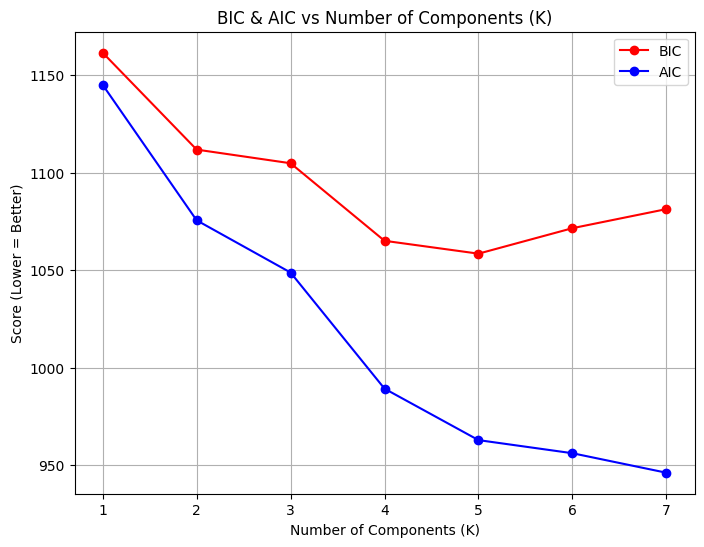

✅ Best K by BIC: 5
✅ Best K by AIC: 7


In [55]:
Ks = range(1, 8)   #  We will try from 1 to 7 clusters
bic_values = []
aic_values = []
log_liks = []

for K in Ks:
    gmm_res = gmm_em(X_scaled, n_components=K, max_iters=200, tol=1e-6, reg_covar=1e-6, init_method='kmeans', verbose=False)
    ll = gmm_res['log_likelihoods'][-1]
    n_params = count_gmm_parameters(K, X_scaled.shape[1])
    bic, aic = compute_bic_aic(ll, n_params, X_scaled.shape[0])
    bic_values.append(bic)
    aic_values.append(aic)
    log_liks.append(ll)

# Plot
plt.figure(figsize=(8,6))
plt.plot(Ks, bic_values, marker='o', label='BIC', color='red')
plt.plot(Ks, aic_values, marker='o', label='AIC', color='blue')
plt.title("BIC & AIC vs Number of Components (K)")
plt.xlabel("Number of Components (K)")
plt.ylabel("Score (Lower = Better)")
plt.legend()
plt.grid(True)
plt.show()

best_k_bic = Ks[np.argmin(bic_values)]
best_k_aic = Ks[np.argmin(aic_values)]
print(f"✅ Best K by BIC: {best_k_bic}")
print(f"✅ Best K by AIC: {best_k_aic}")
# ================================================================================================================================================================================================

In [56]:
# ================================================================================================================================================================================================
print(f"Number of clusters(K):{k}")
print(f"Shape of means:{means.shape}")
print(f"Number of elements in covs:{len(covs)}")
# ================================================================================================================================================================================================

Number of clusters(K):6
Shape of means:(3, 2)
Number of elements in covs:3


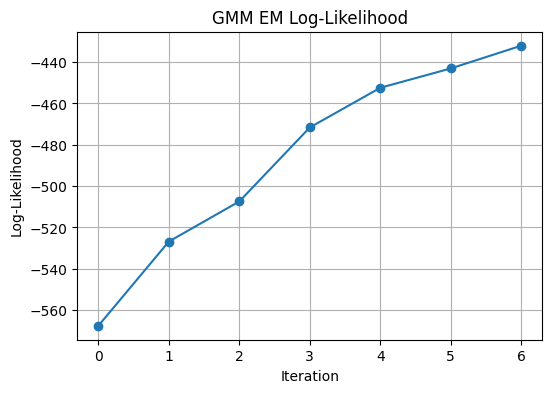

In [57]:
# Plot log-likelihood over iterations
# -------------------------
plt.figure(figsize=(6,4))
plt.plot(log_liks, marker='o')
plt.title('GMM EM Log-Likelihood')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.show()

# ================================================================================================================================================================================================

In [58]:
from sklearn.metrics import silhouette_score

# =====================================
# Model Selection: BIC, AIC & Silhouette vs K
# =====================================

Ks = range(2, 8)  # test cluster counts (start from 2 for Silhouette validity)
bic_values = []
aic_values = []
silhouette_values = []
log_liks = []

for K in Ks:
    print(f"\nRunning GMM for K = {K} ...")
    gmm_res = gmm_em(
        X_scaled, 
        n_components=K, 
        max_iters=200, 
        tol=1e-6, 
        reg_covar=1e-6, 
        init_method='kmeans', 
        verbose=False
    )
    
    ll = gmm_res['log_likelihoods'][-1]
    n_params = count_gmm_parameters(K, X_scaled.shape[1])
    bic, aic = compute_bic_aic(ll, n_params, X_scaled.shape[0])
    
    # Hard cluster assignments (most probable component)
    labels = np.argmax(gmm_res['responsibilities'], axis=1)
    
    # Compute silhouette (only if >1 cluster)
    try:
        sil = silhouette_score(X_scaled, labels)
    except Exception:
        sil = np.nan
    
    # Store metrics
    bic_values.append(bic)
    aic_values.append(aic)
    silhouette_values.append(sil)
    log_liks.append(ll)
# ================================================================================================================================================================================================


Running GMM for K = 2 ...

Running GMM for K = 3 ...

Running GMM for K = 4 ...

Running GMM for K = 5 ...

Running GMM for K = 6 ...

Running GMM for K = 7 ...


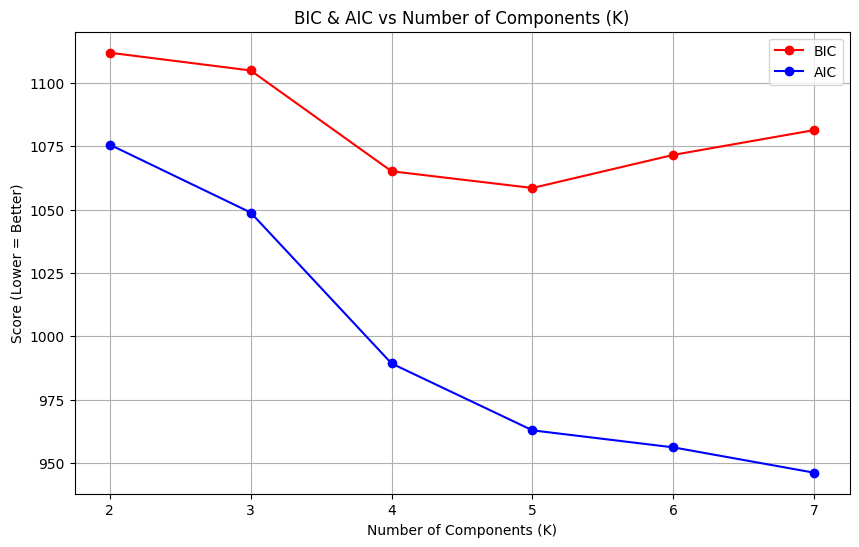

In [59]:
# Plot comparison
# -------------------------
plt.figure(figsize=(10,6))
plt.plot(Ks, bic_values, marker='o', label='BIC', color='red')
plt.plot(Ks, aic_values, marker='o', label='AIC', color='blue')
plt.title("BIC & AIC vs Number of Components (K)")
plt.xlabel("Number of Components (K)")
plt.ylabel("Score (Lower = Better)")
plt.legend()
plt.grid(True)
plt.show()
# ================================================================================================================================================================================================

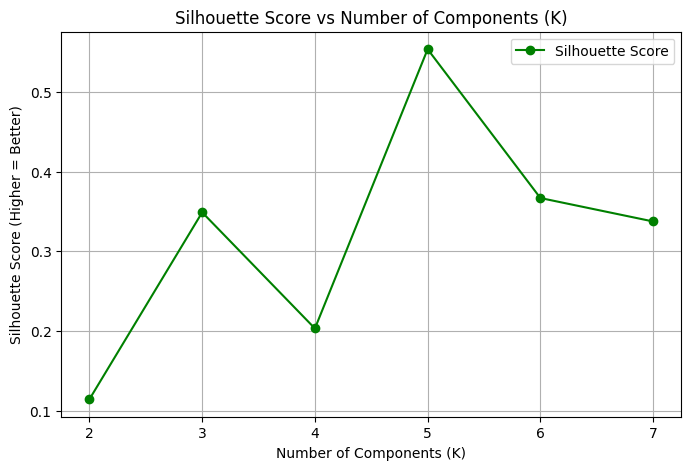


✅ Best K by BIC: 5
✅ Best K by AIC: 7
✅ Best K by Silhouette: 5


In [60]:
plt.figure(figsize=(8,5))
plt.plot(Ks, silhouette_values, marker='o', color='green', label='Silhouette Score')
plt.title("Silhouette Score vs Number of Components (K)")
plt.xlabel("Number of Components (K)")
plt.ylabel("Silhouette Score (Higher = Better)")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------
# Display best values
# -------------------------
best_k_bic = Ks[np.argmin(bic_values)]
best_k_aic = Ks[np.argmin(aic_values)]
best_k_sil = Ks[np.nanargmax(silhouette_values)]

print(f"\n✅ Best K by BIC: {best_k_bic}")
print(f"✅ Best K by AIC: {best_k_aic}")
print(f"✅ Best K by Silhouette: {best_k_sil}")
# ================================================================================================================================================================================================

In [61]:
# Compare with sklearn's GaussianMixture
# -------------------------
gmm_sklearn = GaussianMixture(n_components=K, covariance_type='full', reg_covar=1e-6, random_state=42, n_init=5)
gmm_sklearn.fit(X_scaled)
sk_labels = gmm_sklearn.predict(X_scaled)
sk_probs = gmm_sklearn.predict_proba(X_scaled)

print("\nSklearn GMM weights:", gmm_sklearn.weights_)
print("Sklearn GMM means (scaled):\n", gmm_sklearn.means_)
print("Sklearn Silhouette (hard labels):", silhouette_score(X_scaled, sk_labels))
#================================================================================================================================================================================================


Sklearn GMM weights: [0.0952455  0.1832831  0.19185688 0.10314034 0.29814907 0.06004568
 0.06827943]
Sklearn GMM means (scaled):
 [[ 0.71681738 -1.50371382]
 [-0.54741375 -0.17852491]
 [ 0.98719191  1.24779453]
 [-1.35585412  1.16113531]
 [-0.14894751 -0.04965938]
 [-1.37069402 -1.57445288]
 [ 1.59952381 -1.08188196]]
Sklearn Silhouette (hard labels): 0.38520939104617313


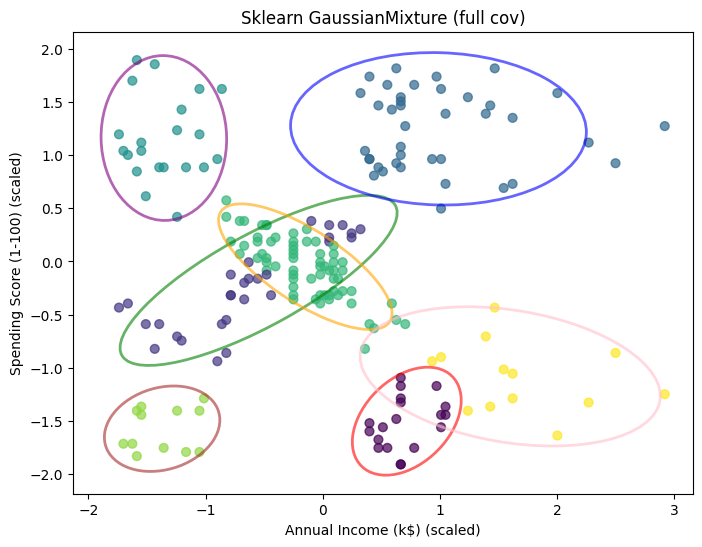

In [62]:
# Now, We will plot sklearn results (ellipses)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X_scaled[:,0], X_scaled[:,1], c=sk_labels, cmap='viridis', s=40, alpha=0.7)

colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

for k in range(K):
    plot_cov_ellipse(ax, gmm_sklearn.means_[k], gmm_sklearn.covariances_[k], n_std=2.0,
                     edgecolor=colors[k % len(colors)], alpha=0.6)

ax.set_title('Sklearn GaussianMixture (full cov)')
ax.set_xlabel(features[0]+" (scaled)")
ax.set_ylabel(features[1]+" (scaled)")
plt.show()
# ================================================================================================================================================================================================